In [1]:
import numpy as np
from numpy.linalg import svd
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
figsize = (20,30)

In [2]:
img_path1 = 'res3/IMG_1642.png'
img_path2 = 'res3/IMG_1645.png'

img1 = cv2.imread(img_path1, 0)  #queryimage # left image
img2 = cv2.imread(img_path2, 0) #trainimage # right image

pts1 = np.array([(1798, 226), (1967, 811), (2260, 968), (1747, 1207), (2070, 1071), (2523, 1385), (2942, 1551), (3452, 1122)])
pts2 = np.array([(1135, 937), (1429, 1396), (1610, 1549), (1075, 1714), (1497, 1617), (1767, 1891), (1989, 2028), (2226, 1746)])

In [3]:
import matplotlib.colors as mcolors

def hex2rgb(hex):
  h = hex.lstrip('#')
  return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    colors = mcolors.TABLEAU_COLORS
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        hex_color = list(colors.items())[i][1]
        color = hex2rgb(hex_color)
        i += 1
        
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,5)
        img1 = cv2.circle(img1,tuple(pt1),25,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),25,color,-1)
    return img1,img2

## Our Implementation

In [4]:
# as a skeleton, matlab implementation was used
# https://uk.mathworks.com/matlabcentral/fileexchange/54544-normalise2dpts-pts
def normalise2dpts(pts):
  N = pts.shape[1]
  pts = np.vstack((pts, np.ones(N)))
  assert pts.shape[0] == 3
  
# Find the indices of the points that are not at infinity
  eps = 1e-7
  finiteind = pts[2,:] > eps
    
  if len(finiteind) != pts.shape[1]:
    print('Some points are at infinity. Please, select different points')
    return

  mean = np.mean(pts[:2], axis=1)
  
  S = np.sqrt(2) / np.std(pts[:2])
  T = np.array([[S, 0, -S*mean[0]],
                [0, S, -S*mean[1]],
                [0, 0,     1    ]])
  return (np.dot(T, pts), T)


# creates a homogeneous system Af=0 (f : elements of fundamental matrix), using pts*F*pts'=0
def getHomogeneousMatrix(pts1,pts2):
  N = pts1.shape[1]
  A = np.zeros((N,9))
  A[:,0]= pts2[0,:].T * pts1[0,:].T
  A[:,1]= pts2[0,:].T * pts1[1,:].T
  A[:,2]= pts2[0,:].T
  A[:,3]= pts2[1,:].T * pts1[0,:].T
  A[:,4]= pts2[1,:].T * pts1[1,:].T
  A[:,5]= pts2[1,:].T
  A[:,6]= pts1[0,:].T
  A[:,7]= pts1[1,:].T
  A[:,8]= np.ones(N)
  
  return A
  

def fundamental_matrix(pts1,pts2):		
  # normalising points
  pts1,T1 = normalise2dpts(pts1.T)
  pts2,T2 = normalise2dpts(pts2.T)
    
  # use the eigenvector that corresponds to the smallest eigenvalue as initial estimate for F.
  A = getHomogeneousMatrix(pts1, pts2)
  U, s, Vh = svd(A)
  F = np.reshape(Vh.T[:,8], (3,3))
  
  # make sure that fundamental matrix is of rank 2, by zeroing out the samllest eigenvalue
  U,s,V = svd(F)
  s[2] = 0
  F = np.dot(U, np.dot(np.diag(s), V))
  
  # denormalise
  F = np.dot(T2.T, np.dot(F,T1))
  
  # to match OpenCV behavior, F[2,2] should be equal 1
  return F / F[2, 2]

  
F = fundamental_matrix(pts1, pts2)
F

array([[-5.07777732e-07, -5.96079395e-06,  7.74710026e-03],
       [ 9.74359404e-06, -1.27089340e-06,  1.25166184e-02],
       [-1.75921015e-02, -1.46388398e-02,  1.00000000e+00]])

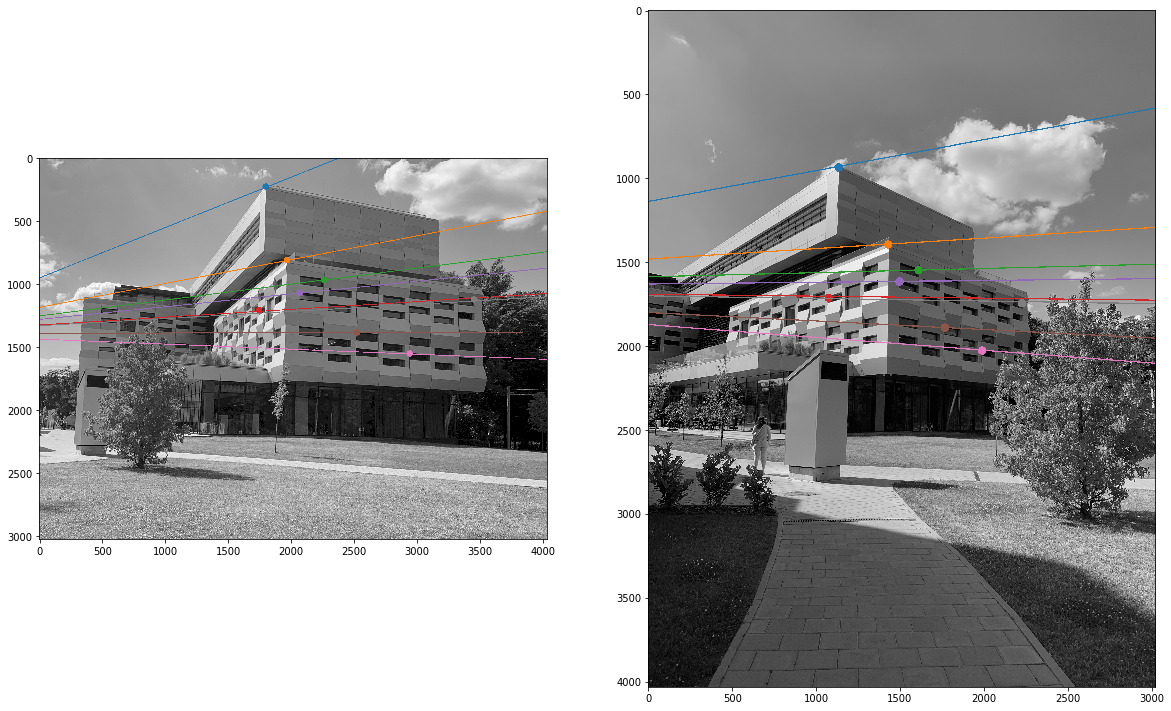

In [5]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=figsize)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

## OpenCV Implementatio

In [6]:
F, mask = cv2.findFundamentalMat(pts1, pts2 ,cv2.FM_8POINT)
print(F)

[[-5.06830200e-07 -6.03318865e-06  7.85226750e-03]
 [ 9.85999349e-06 -1.28609184e-06  1.26679791e-02]
 [-1.78176913e-02 -1.48130039e-02  1.00000000e+00]]


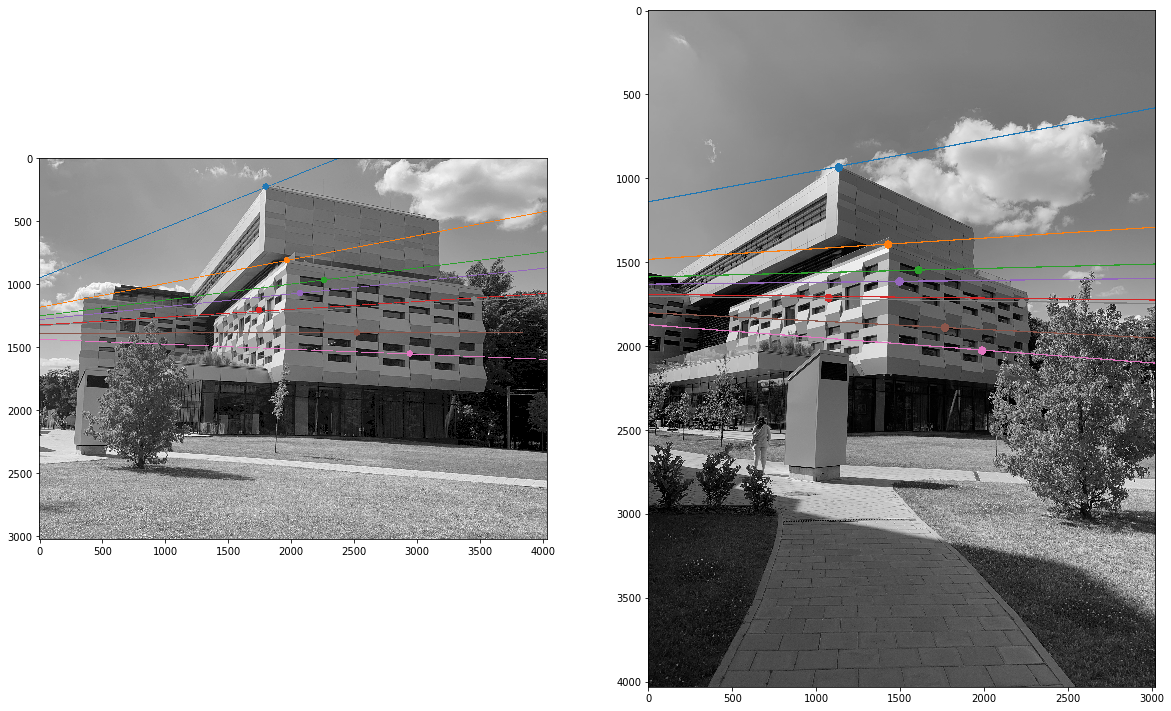

In [7]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=figsize)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()